In [7]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import spacy
from textblob import TextBlob
import fitz  # PyMuPDF til at læse PDF-filer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import string
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud  # Til ordsky
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.text_rank import TextRankSummarizer  # Brug TextRank til opsummering
from langdetect import detect  # Sprogdetektering
import ipywidgets as widgets
from IPython.display import display
import networkx as nx  # Importer NetworkX til mind mapping
import numpy as np
from nrclex import NRCLex


# Indlæs både dansk og engelsk model i spaCy
nlp_da = spacy.load("da_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

# For at opdele teksten i sektioner
nltk.download('punkt')
from nltk import sent_tokenize

# Globale variable til at gemme tekst
cleaned_text_global = None
themes_global = None

# Funktioner til at læse, rense, analysere og visualisere
def read_pdf(file_path):
    text = ""
    with fitz.open(file_path) as pdf:
        for page_num in range(pdf.page_count):
            page = pdf[page_num]
            text += page.get_text()
    return text

def clean_text(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Fjern URL'er
    text = re.sub(r'\b(Terms|Conditions|Journal|homepage|ISSN|access|use)\b', '', text, flags=re.IGNORECASE)  # Fjern metadata-ord
    return text

# Funktion til at opsummere tekst og formatere den præsentabelt
def summarize_text(text, sentence_count=3):
    """
    Opsummerer tekst ved hjælp af TextRank algoritmen.

    Parameters:
    text (str): Teksten, der skal opsummeres.
    sentence_count (int): Antal sætninger i opsummeringen.

    Returns:
    str: En opsummeret tekst med linjeskift.
    """
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, sentence_count)
    
    # Formater opsummeringen med linjeskift eller punkttegn
    formatted_summary = "\n".join(f"- {str(sentence)}" for sentence in summary)
    return formatted_summary



# Funktion til at generere en ordsky uden stopord
def generate_wordcloud(text):
    tokens = word_tokenize(text.lower())
    stop_words = set(nlp_da.Defaults.stop_words) | set(string.punctuation)
    filtered_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    
    filtered_text = ' '.join(filtered_tokens)
    
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(filtered_text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title("Ordsky over nøgleord i teksten")
    plt.show()
    
# Funktion til sentimentanalyse
def sentiment_analysis(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment
    return sentiment

# Funktion til at detektere sprog
def detect_language(text):
    return detect(text)



def identify_themes(text):
    language = detect_language(text)
    if language == "da":
        nlp = nlp_da
        stop_words = nlp.Defaults.stop_words | set(string.punctuation)
    elif language == "en":
        nlp = nlp_en
        stop_words = nlp.Defaults.stop_words | set(string.punctuation) | {"the", "a", "of", "and", "in", "to", "is", "as", "it", "on"}
    else:
        return []
    
    tokens = word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word not in stop_words and word.isalpha()]
    freq_dist = FreqDist(filtered_tokens)
    common_words = freq_dist.most_common(10)
    return common_words

# Funktion til at visualisere temaerne
def plot_themes(common_words):
    words, frequencies = zip(*common_words)
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bars = ax.bar(words, frequencies, color=plt.cm.viridis(range(len(words))))
    
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.set_xlabel("Ord", fontsize=14)
    ax.set_ylabel("Frekvens", fontsize=14)
    ax.set_title("De mest almindelige ord i teksten", fontsize=16, fontweight='bold')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Funktion til at visualisere sentimentanalyse som linjediagram
def plot_sentiment_line(sentiment):
    polarity = sentiment.polarity
    subjectivity = sentiment.subjectivity
    
    labels = ['Polarity', 'Subjectivity']
    values = [polarity, subjectivity]

    plt.style.use('seaborn-darkgrid')
    fig, ax = plt.subplots(figsize=(8, 5))

    ax.plot(labels, values, marker='o', color='#ff7043', markersize=10, linewidth=2.5, label="Sentiment")
    
    for i, value in enumerate(values):
        ax.text(i, value + 0.05, f"{value:.3f}", ha='center', fontsize=12, fontweight='bold')

    ax.set_ylim(-1, 1)
    ax.set_ylabel("Værdi", fontsize=14)
    ax.set_xlabel("Sentiment Parametre", fontsize=14)
    ax.set_title("Sentimentanalyse - Linjediagram", fontsize=16, fontweight='bold')
    ax.legend(loc='upper right', fontsize=12)
    plt.tight_layout()
    plt.show()

    
# Funktion til at opsummere teksten med TextRank
def summarize_text(text, sentences_count=3):
    parser = PlaintextParser.from_string(text, Tokenizer("danish"))
    summarizer = TextRankSummarizer()
    summary = summarizer(parser.document, sentences_count)
    return ' '.join(str(sentence) for sentence in summary)


# Mind map-funktion
def create_mind_map(themes):
    G = nx.Graph()
    G.add_node("Hovedemne")
    for word, frequency in themes:
        G.add_node(word)
        G.add_edge("Hovedemne", word, weight=frequency)
    
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 8))
    edges = G.edges(data=True)
    edge_colors = [edge[2]['weight'] for edge in edges]
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=1.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues)
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=3000)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    plt.title("Mind Map over Temaer", fontsize=16)
    plt.axis('off')
    plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Blues), label='Vægt')
    plt.show()
    

# ESKTRA FUNKTIONER, SOM KAN KALDES

# 1 SENTIMENTANALYSE

# Funktion til at visualisere sentiment over tid
def sentiment_over_time(text):
    # Del teksten op i sætninger
    sentences = text.split('.')
    polarities = []
    subjectivities = []
    
    # Beregn polarity og subjectivity for hver sætning
    for sentence in sentences:
        if sentence.strip():  # Tjek at sætningen ikke er tom
            blob = TextBlob(sentence)
            polarities.append(blob.sentiment.polarity)
            subjectivities.append(blob.sentiment.subjectivity)
    
    # Visualiser polarity og subjectivity over tid
    plt.figure(figsize=(12, 6))
    plt.plot(polarities, label="Polarity", color='blue')
    plt.plot(subjectivities, label="Subjectivity", color='orange')
    plt.xlabel("Sætning nr.")
    plt.ylabel("Sentimentværdi")
    plt.title("Sentimentanalyse over tid")
    plt.legend()
    plt.show()
    
# Funktion til udvidet emotionel analyse
def extended_emotion_analysis(text):
    # Lav NRCLex-analyse på hele teksten
    emotion = NRCLex(text)
    
    # Saml resultaterne i en ordbog
    emotion_counts = emotion.raw_emotion_scores  # Får en ordbog med følelseskategorier og antal
    total_words = sum(emotion_counts.values())
    
    # Konverter til procent
    emotion_percentages = {emotion: count / total_words for emotion, count in emotion_counts.items()}
    
    # Visualiser emotionerne som et søjlediagram
    plt.figure(figsize=(10, 6))
    plt.bar(emotion_percentages.keys(), emotion_percentages.values(), color='skyblue')
    plt.xlabel("Følelser")
    plt.ylabel("Procentdel af ord")
    plt.title("Emotionel Analyse af Teksten")
    plt.show()
    
    
# Funktion til at beregne sentiment pr. sektion
def sentiment_per_section(text, section_length=500):
    """
    Opdeler teksten i sektioner og beregner sentiment for hver sektion.
    
    Parameters:
    text (str): Teksten som skal analyseres
    section_length (int): Antal ord pr. sektion
    
    Returns:
    list: Liste af sentiment scores for hver sektion
    """
    from textblob import TextBlob
    
    # Opdel tekst i sektioner
    words = text.split()
    sections = [words[i:i + section_length] for i in range(0, len(words), section_length)]
    
    # Beregn sentiment for hver sektion
    sentiment_scores = []
    for section in sections:
        section_text = " ".join(section)
        blob = TextBlob(section_text)
        sentiment_scores.append({
            "polarity": blob.sentiment.polarity,
            "subjectivity": blob.sentiment.subjectivity
        })
        
    return sentiment_scores
# Funktion til at plotte sentiment på tværs af sektioner
def plot_sentiment_comparison(sentiment_scores):
    """
    Visualiser sentiment (polarity og subjectivity) på tværs af sektioner.
    
    Parameters:
    sentiment_scores (list): Liste af sentiment scores pr. sektion
    """
    sections = list(range(1, len(sentiment_scores) + 1))
    polarity = [score['polarity'] for score in sentiment_scores]
    subjectivity = [score['subjectivity'] for score in sentiment_scores]
    
    plt.figure(figsize=(12, 6))
    
    # Polarity plot
    plt.plot(sections, polarity, label='Polarity', marker='o', color='b')
    plt.fill_between(sections, polarity, color='b', alpha=0.2)
    
    # Subjectivity plot
    plt.plot(sections, subjectivity, label='Subjectivity', marker='o', color='g')
    plt.fill_between(sections, subjectivity, color='g', alpha=0.2)
    
    plt.title("Sentiment på Tværs af Sektioner")
    plt.xlabel("Sektion")
    plt.ylabel("Score")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()
    
# Funktion til at generere sentiment-baseret ordsky
def generate_sentiment_wordcloud(text):
    """
    Opretter en sentiment-baseret ordsky.
    
    Parameters:
    text (str): Tekst til analyse og ordsky.
    """
    blob = TextBlob(text)
    words = blob.words

    # Skab en ordfrekvens- og sentiment-dictionary
    word_sentiments = {}
    for word in words:
        word_blob = TextBlob(word)
        polarity = word_blob.sentiment.polarity
        word_sentiments[word] = polarity

    # Konfigurer WordCloud med sentiment som farvekode
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='coolwarm',  # Bruger coolwarm farvepalette til negativ/positiv
                          contour_color='black',
                          contour_width=1).generate_from_frequencies(word_sentiments)

    # Plot WordCloud
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title("Sentiment Word Cloud")
    plt.show()


[nltk_data] Downloading package punkt to /Users/aw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/aw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aw/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


FileUpload(value=(), accept='.pdf', description='Upload')

Opsummering af teksten:

Furthermore, forecasts predict that there will be a shortage of skilled workers by 2030 (Damm, Nielsen, & Jensen, 2021; Labour and skills shortages in the EU: an action plan, 2024) that can only be addressed by attracting more participants into VET. The 2023 edition of the OECD’s Education at a Glance points to the fact that participation rates in VET at upper secondary level vary from country to country while underlining that despite a high average participation rate of 44 % VET enrolment across OECD countries, VET is in many countries ‘still seen as a last resort’ (OECD, 2023b). Thus, the idea of the knowledge economy implied a ‘significant expansion of general education’ (Jørgensen, Stenström, Thunqvist, & Tønder, 2013, p. 1) The discourse surrounding the knowledge economy changed after the 2008 financial crisis, with policymakers forced to abandon the idea of Europe as home to world-leading innovation and creativity and refocus on the manufacturing and prod

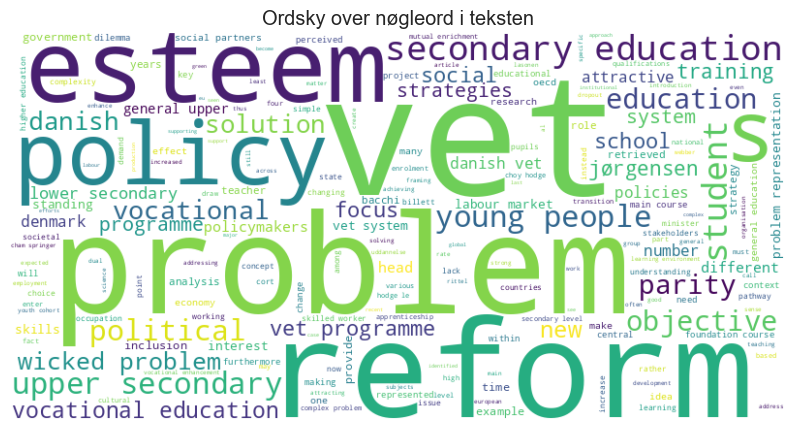

Sentimentanalyse:
Polarity (stemning): 0.08446906759485776
Subjectivity (subjektivitet): 0.378723623616165


/var/folders/n8/2w71rbx500zg4xscpp7ccm2h0000gn/T/ipykernel_3385/165971240.py:144: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


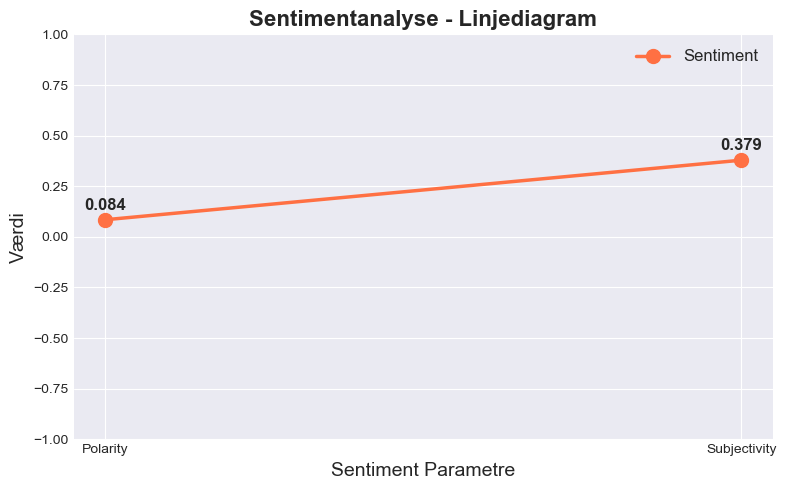


Identificerede temaer (mest almindelige ord):
vet: 154
education: 92
problem: 64
reform: 51
vocational: 47
secondary: 46
problems: 44
esteem: 42
danish: 37
policy: 33


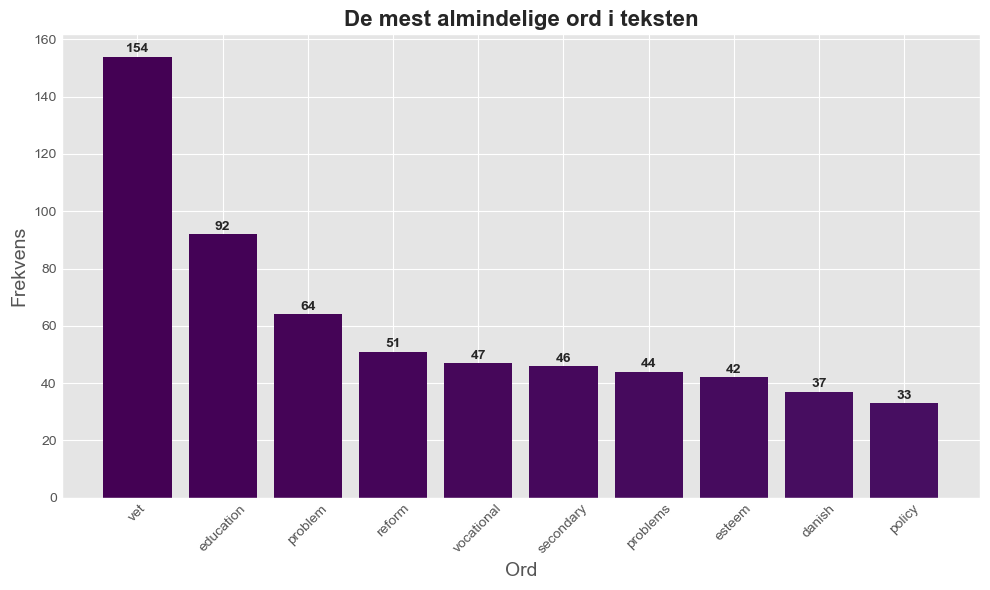

/var/folders/n8/2w71rbx500zg4xscpp7ccm2h0000gn/T/ipykernel_3385/165971240.py:186: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.Blues), label='Vægt')


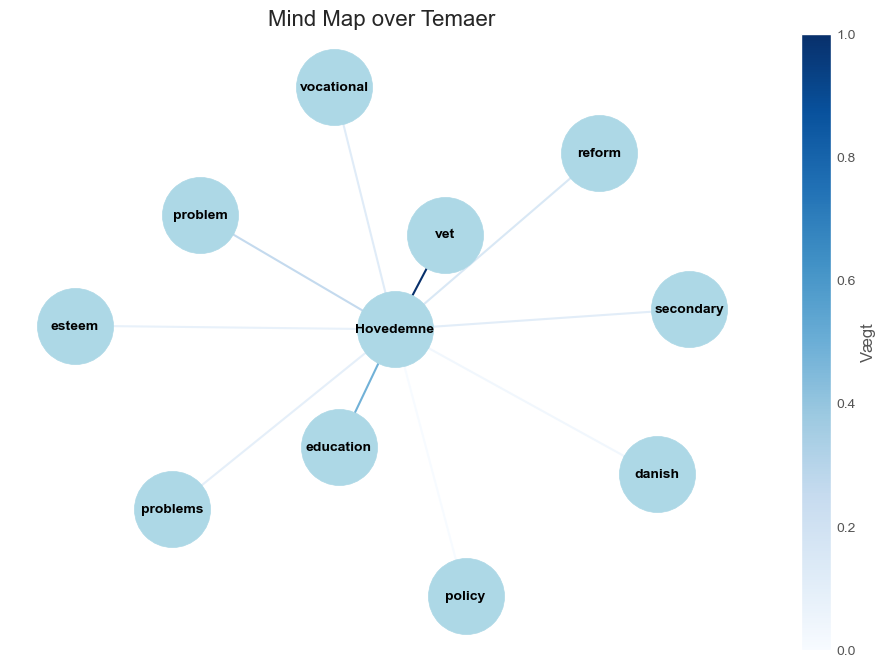

In [9]:
def upload_file(change):
    global cleaned_text_global, themes_global  # Brug de globale variable
    uploaded_file = change['new'][0]
    file_path = uploaded_file['name']
    with open(file_path, 'wb') as f:
        f.write(uploaded_file['content'])

    text = read_pdf(file_path)
    cleaned_text = clean_text(text)
    
    if len(cleaned_text.strip()) == 0:
        print("Renset tekst er tom. Tjek PDF-filen.")
    else:
         # Gem renset tekst i den globale variabel tidligt
        cleaned_text_global = cleaned_text  
        
        # Opsummering af teksten
        summary = summarize_text(cleaned_text_global, sentences_count=2)
        print("Opsummering af teksten:\n")

        print(summary)
        
        generate_wordcloud(cleaned_text)
        sentiment = sentiment_analysis(cleaned_text)
        print("Sentimentanalyse:")
        print(f"Polarity (stemning): {sentiment.polarity}")
        print(f"Subjectivity (subjektivitet): {sentiment.subjectivity}")
        plot_sentiment_line(sentiment)
        themes = identify_themes(cleaned_text)
        print("\nIdentificerede temaer (mest almindelige ord):")
        for word, frequency in themes:
            print(f"{word}: {frequency}")
        plot_themes(themes)
        create_mind_map(themes)


        cleaned_text_global = cleaned_text  # Gem renset tekst i den globale variabel
        themes_global = themes  # Gem temaer i den globale variabel

# Opret en upload widget
upload_widget = widgets.FileUpload(accept='.pdf', multiple=False)
upload_widget.observe(upload_file, names='value')
display(upload_widget)

cleaned_text_global er tilgængelig.
 
1 
 
The wicked problem of making VET attractive – 
dilemmas in Danish VET policy. 
 
Abstract: 
Vocational education and training (VET) has become a focus of attention, seen as a solution to 
many contemporary societal problems. The EU, for example, regards VET as playing a vital role in 
digitalisation and the transition to a green economy, pointing to the need to attract more students 
to VET rather than general upper secondary education. Both transnational organisations and 
national gover


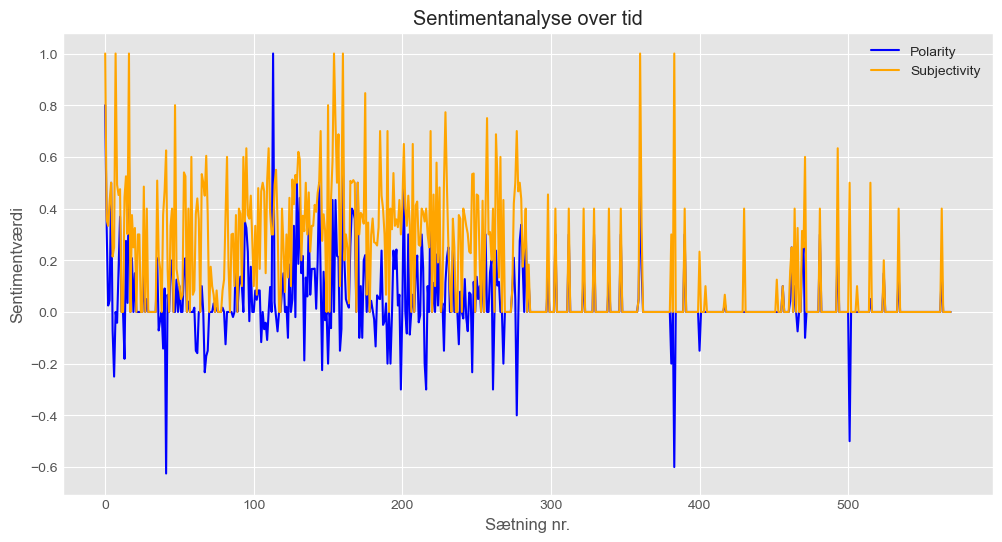

In [17]:
# Kontroller indholdet af cleaned_text_global
if 'cleaned_text_global' in globals():
    print("cleaned_text_global er tilgængelig.")
    print(cleaned_text_global[:500])  # Udskriv de første 500 tegn for at bekræfte
    sentiment_over_time(cleaned_text_global)

else:
    print("cleaned_text_global er ikke defineret.")


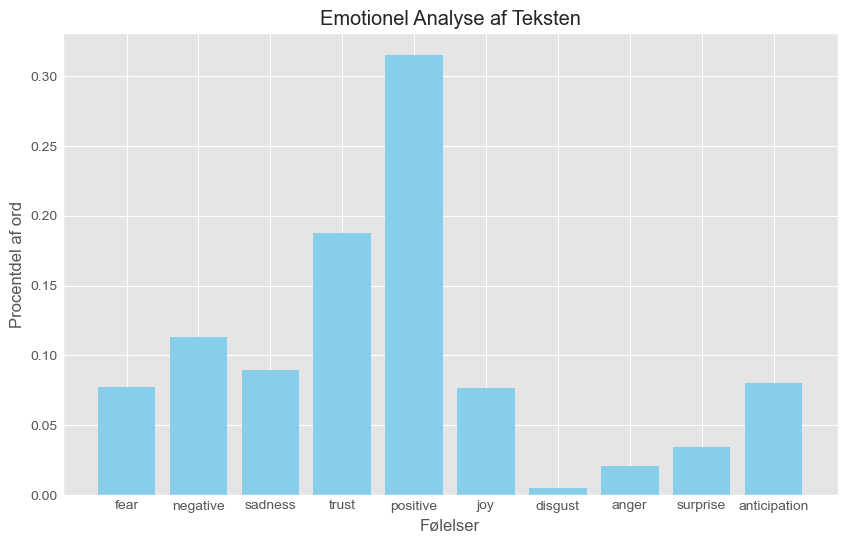

In [18]:
# Analyserer hele teksten: NRCLex laver en emotionel analyse af teksten, hvor hver kategori får tildelt en 
# score baseret på antallet af ord, der matcher med den pågældende følelse.

# Kør emotionel analyse på den globale rensede tekst
extended_emotion_analysis(cleaned_text_global)

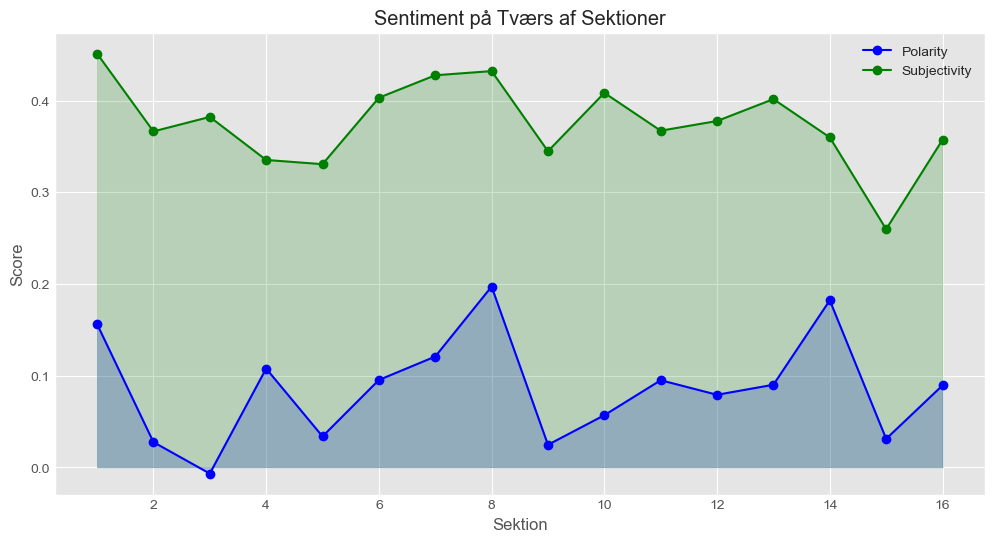

In [19]:
# Antag, at cleaned_text_global indeholder den rensede tekst
sentiment_scores = sentiment_per_section(cleaned_text_global, section_length=500)
plot_sentiment_comparison(sentiment_scores)


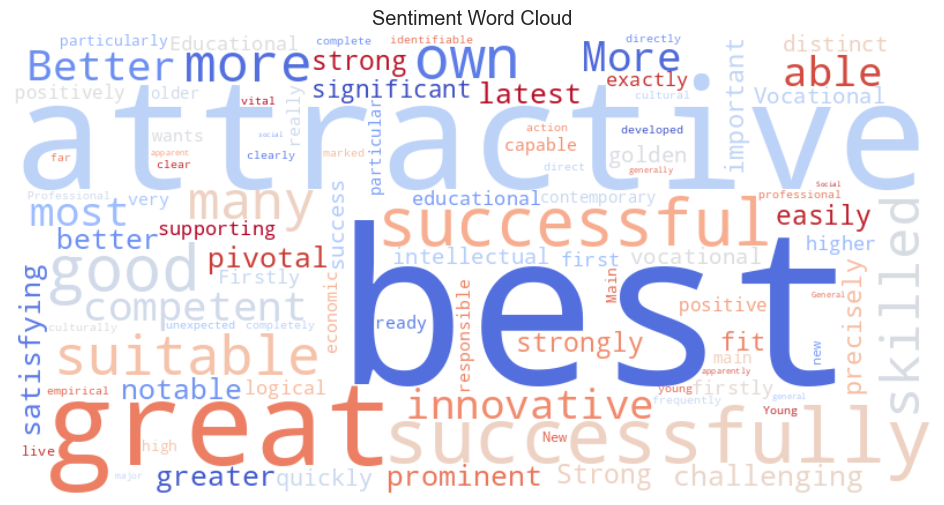

In [20]:
generate_sentiment_wordcloud(cleaned_text_global)